In [1]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

/home/smadper/pyenvs/tfm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LaticiferPatchTrain(Dataset):
    def __init__(self, df, root_dir, patch_size=(512, 512), num_patches=20, augment=True):
        self.df = df
        self.root = root_dir
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.augment = augment

        self.transforms = A.Compose([
            A.RandomCrop(*patch_size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ElasticTransform(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ])

        self.samples = []
        for idx in range(len(self.df)):
            for _ in range(num_patches):
                self.samples.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row_idx = self.samples[idx]
        row = self.df.iloc[row_idx]

        enhanced_path = os.path.join(self.root, row['enhanced_img_path'])
        mask_path = os.path.join(self.root, row['mask_path'])

        image = np.array(Image.open(enhanced_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255

        augmented = self.transforms(image=image, mask=mask)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask'].unsqueeze(0).float()

        return image_tensor, mask_tensor


class LaticiferPatchTest(Dataset):
    def __init__(self, df, root_dir, patch_size=(512, 512), stride=(256, 256)):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.patch_size = patch_size
        self.stride = stride
        self.transforms = A.Compose([
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row['enhanced_img_path'])
        mask_path = os.path.join(self.root, row['mask_path'])

        image = np.array(Image.open(img_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255
        original_size = image.shape  # (H, W)

        pad_h = (self.patch_size[0] - image.shape[0] % self.patch_size[0]) % self.patch_size[0]
        pad_w = (self.patch_size[1] - image.shape[1] % self.patch_size[1]) % self.patch_size[1]

        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant')

        H, W = image.shape
        patches = []
        mask_patches = []
        coords = []

        for top in range(0, H - self.patch_size[0] + 1, self.stride[0]):
            for left in range(0, W - self.patch_size[1] + 1, self.stride[1]):
                img_patch = image[top:top+self.patch_size[0], left:left+self.patch_size[1]]
                mask_patch = mask[top:top+self.patch_size[0], left:left+self.patch_size[1]]
                transformed = self.transforms(image=img_patch, mask=mask_patch)
                patches.append(transformed['image'])  # [1, H, W]
                mask_patches.append(transformed['mask'].unsqueeze(0).float())
                coords.append((top, left))

        return {
            'image_patches': torch.stack(patches),
            'mask_patches': torch.stack(mask_patches),
            'coords': coords,
            'image_size': (H, W),             # padded size
            'original_size': original_size,   # original size
            'image_idx': idx
        }

In [3]:
dataset_root = '/home/smadper/TFM/datasets/laticifers'
dataset_csv = 'laticifer_dataset_index.csv'
patch_size = (512, 512)
stride = (256, 256)
num_patches = 20
batch_size = 8
num_workers = 4

df = pd.read_csv(os.path.join(dataset_root, dataset_csv))
df = df[df["is_labeled"] == True].reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = LaticiferPatchTrain(
    df=train_df,
    root_dir=dataset_root,
    patch_size=patch_size,
    num_patches=num_patches,
    augment=True
)
test_dataset = LaticiferPatchTest(
    df=val_df, 
    root_dir=dataset_root,
    patch_size=patch_size,
    stride=stride
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

Training Dataset Examples:


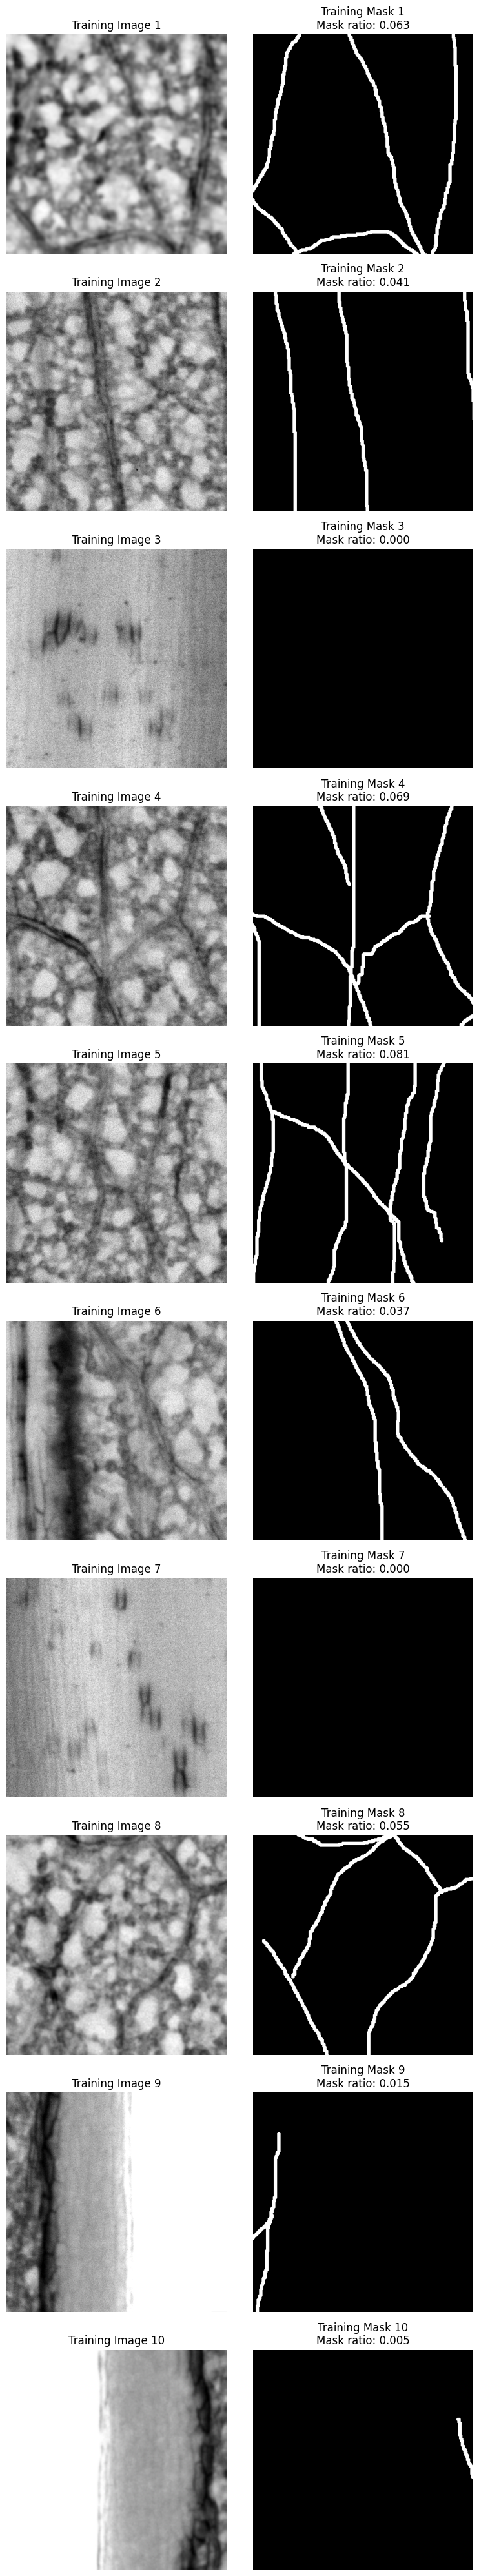


Test Dataset Examples:


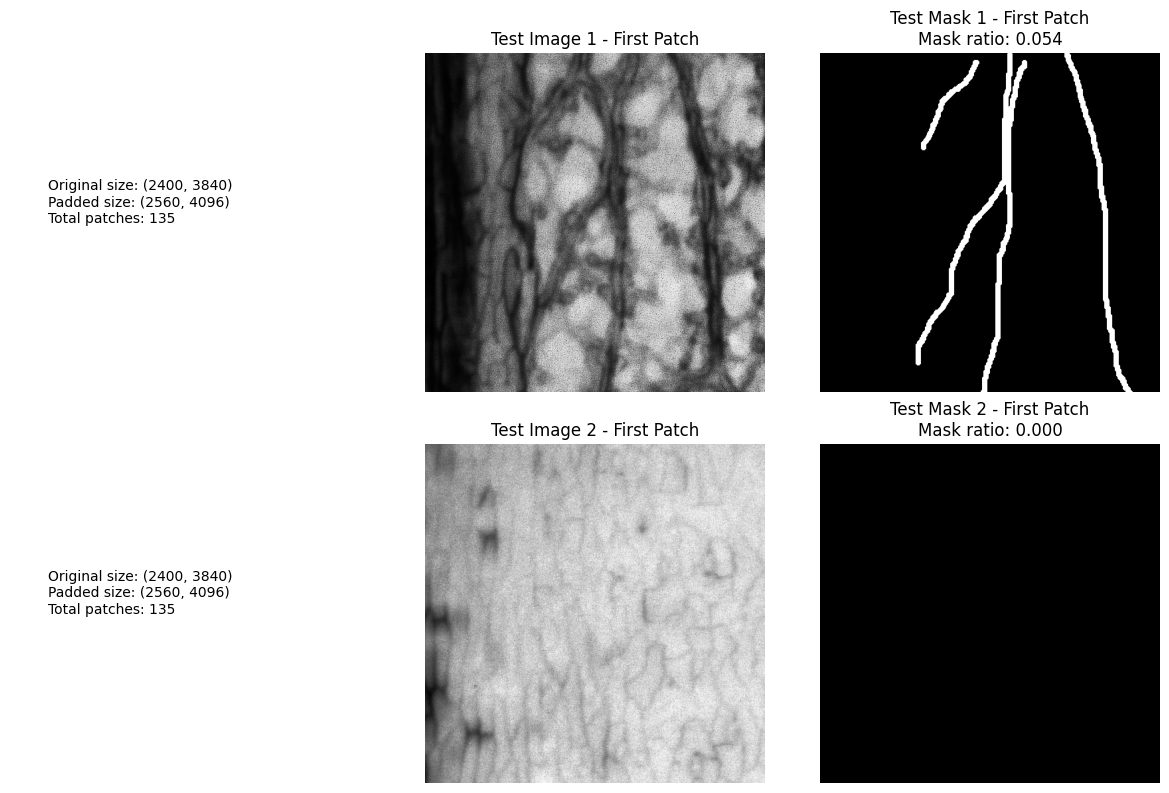

In [4]:
def show_train_samples(train_dataset, num_samples=10):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4*num_samples))
    
    for i in range(num_samples):
        img, mask = train_dataset[i]
        mask_ratio = mask.mean().item()
        
        # Show image
        axes[i,0].imshow(img.squeeze(), cmap='gray')
        axes[i,0].set_title(f'Training Image {i+1}')
        axes[i,0].axis('off')
        
        # Show mask with ratio
        axes[i,1].imshow(mask.squeeze(), cmap='gray')
        axes[i,1].set_title(f'Training Mask {i+1}\nMask ratio: {mask_ratio:.3f}')
        axes[i,1].axis('off')
    
    plt.tight_layout()
    plt.show()

def show_test_samples(test_dataset, num_samples=2):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        sample = test_dataset[i]
        img_patch = sample['image_patches'][0]
        mask_patch = sample['mask_patches'][0]
        mask_ratio = mask_patch.mean().item()
        
        # Show original size info
        axes[i,0].text(0.1, 0.5, f"Original size: {sample['original_size']}\n"
                      f"Padded size: {sample['image_size']}\n"
                      f"Total patches: {len(sample['coords'])}")
        axes[i,0].axis('off')
        
        # Show first patch
        axes[i,1].imshow(img_patch.squeeze(), cmap='gray')
        axes[i,1].set_title(f'Test Image {i+1} - First Patch')
        axes[i,1].axis('off')
        
        # Show mask patch with ratio
        axes[i,2].imshow(mask_patch.squeeze(), cmap='gray')
        axes[i,2].set_title(f'Test Mask {i+1} - First Patch\nMask ratio: {mask_ratio:.3f}')
        axes[i,2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show examples
print("Training Dataset Examples:")
show_train_samples(train_dataset)

print("\nTest Dataset Examples:")
show_test_samples(test_dataset)